[Inhaltsverzeichnis](../AP4.ipynb) | [ < zurück ](wohin?)|  [ > next](wohin?)

## 4.3.1  Szenarien stündlich aufgelöst




FLUCCOplus Setup

In [264]:
# OPTIONAL: Load the "autoreload" extension so that code can change
import pandas as pd
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [266]:
%matplotlib inline
from FLUCCOplus.notebooks import *



### Scenario Überblick
Zuerst werden alle Szenarien aus Excel eingelesen und dargestellt

In [267]:
import FLUCCOplus.scenarios as scens

In [268]:
sc = scens.all()
print(*[i+k for i,k in zip([i for i in sc.index], ["\n"]*len(sc.index))])

EM2018
 EM2019
 E-Control 2019
 Energie und Klimazukunft 2030 (Veigl17)
 Erneuerbare Energie 2030 (UBA16)
 WEM 2030 (UBA17)
 Transition 2030 (UBA17)
 Energie und Klimazukunft 2050 (Veigl17)
 Erneuerbare Energie 2050 (UBA16)
 WEM 2050 (UBA17)
 Transition 2050 (UBA17)
 100% Erneuerbare Deckung 2050 (FLUCCO+)
 100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)



C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


## Creating a Scenario object



In [269]:
from FLUCCOplus.scenarios import Scenario
 

### EM Base data
Select an electricity map year


In [270]:
em_year = 2018 # 2015, 2016, 2017, 2018 # 2019? nicht? # Es fehlen einige Daten im 2019... soll ma mit Null to fill? aber das wird dann zu falschen Ergebnissen führen, oder?

Select an available Scenario ``name`` 

In [271]:
#name = "EM2018"
#name = "EM2019"                                                  
#name = "E-Control 2019"                                          
#name = "Energie und Klimazukunft 2030 (Veigl17)"                 
#name = "Erneuerbare Energie 2030 (UBA16)"                        
#name = "WEM 2030 (UBA17)"                                        
#name = "Transition 2030 (UBA17)"                                 
#name = "Energie und Klimazukunft 2050 (Veigl17)"                
#name = "Erneuerbare Energie 2050 (UBA16)"                        
#name = "WEM 2050 (UBA17)"                                       
name = "Transition 2050 (UBA17)"                                 
#name = "100% Erneuerbare Deckung 2050 (FLUCCO+)"                 
#name = "100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)" 

Create the scenario

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


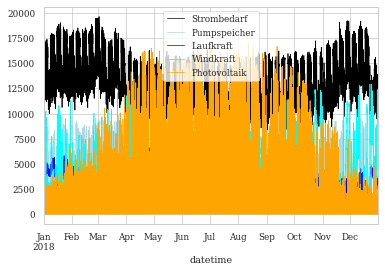

In [272]:
import FLUCCOplus.electricitymap as elmap

s = Scenario(  
    name = name, # can be anything
    scenario = name, # must be a scenario name
    em_base = {"year": em_year,
               "df": elmap.fetch(year=em_year)})
s
s.plot()

In [273]:
import os
if not os.path.exists("..\data\Plots"):
        os.makedirs("..\data\Plots")

[Text(0.5, 1.0, 'Jahresverlauf 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]')]

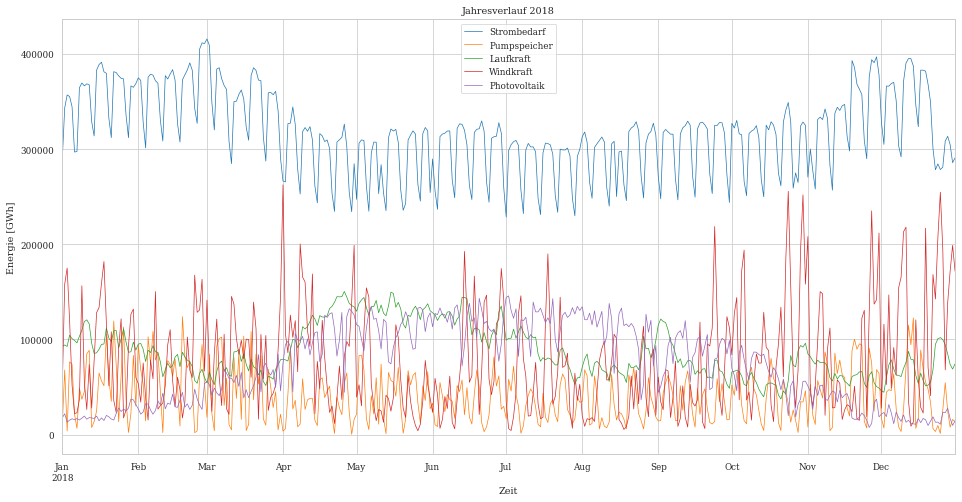

In [274]:
# einheitlichen Plot#
# RES, Energieverbrauch
df = s.TSD
df.resample("D").sum().plot(figsize=(16,8)).set(title="Jahresverlauf " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]")

<AxesSubplot:xlabel='datetime'>

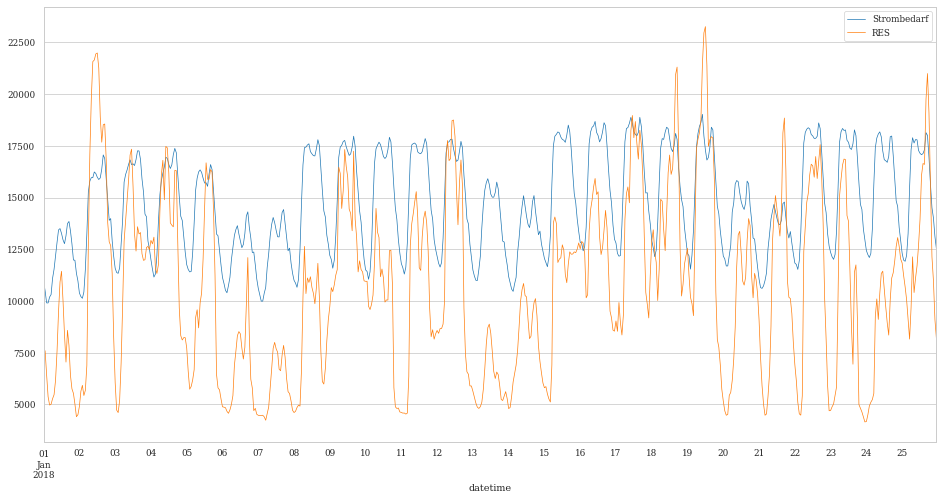

In [275]:
df["Non Volatiles"] = df.Pumpspeicher
df["RES"] = df.Laufkraft + df.Windkraft + df.Photovoltaik + df.Pumpspeicher
df["RESohneWind"] = df.Laufkraft + df.Photovoltaik + df.Pumpspeicher

cols = ["Strombedarf",
#        "RESohneWind",
        "RES",
#        "Non Volatiles",
        #"Windkraft"
         ]

df[cols].iloc[0:600,:].plot(figsize=(16,8))

# Wind
Es wird analisiert, wann Windkrafta als letzte Energiequelle verwendet wird.

C:\Users\EditParáda\AppData\Local\Temp\ipykernel_10992\2409922681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.WindkraftLast[t] = df.Strombedarf[t] - df.RES[t] + df.Windkraft[t]


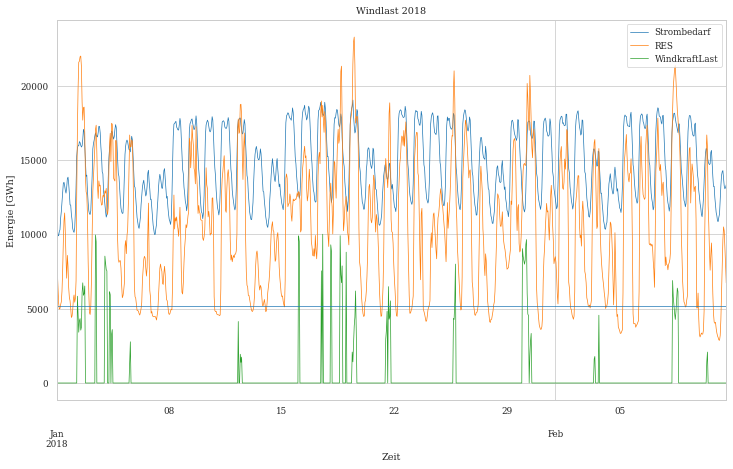

In [276]:
df["WindkraftLast"] = 0

for t in range(8760):
    if (df.RES[t] - df.Strombedarf[t]) > 0:
        df.WindkraftLast[t] = df.Strombedarf[t] - df.RES[t] + df.Windkraft[t]

cols_wind = ["Strombedarf",
        "RES",
        "WindkraftLast"]

df[cols_wind].iloc[0:1000,:].plot(figsize=(12,7)).set(title="Windlast " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]")
plt.axhline(y=df.Windkraft.max()*0.4)
#df[cols].resample("D").sum().plot(figsize=(12,7))


In [277]:
df["Wind_rel"] = df.WindkraftLast / df.Windkraft.max()
df_windrel = df.Wind_rel.where(df.Wind_rel != 0)#.plot()


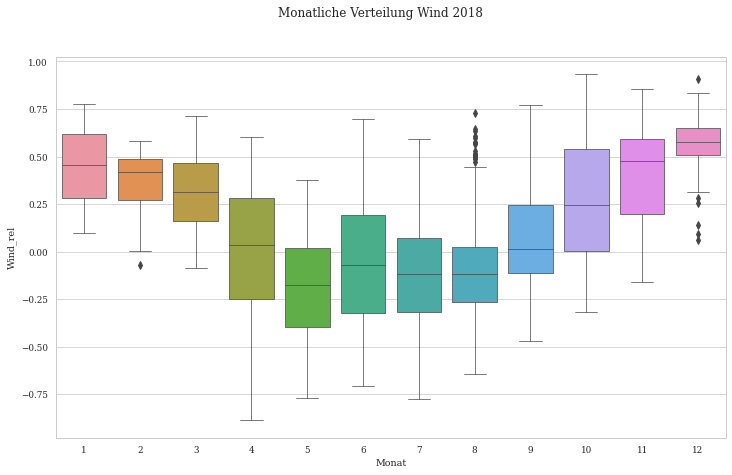

In [278]:
import seaborn as sns
fig, ax = plt.subplots()
sns.boxplot(x=df_windrel.index.month, y=df_windrel, orient="v", ax=ax).set(xlabel='Monat')
fig.set_size_inches(12, 7)
fig.suptitle(f'Monatliche Verteilung Wind {em_year}', fontsize=12)
fig.savefig(f"../data/Plots/Monatlich_wind_{em_year}.png", dpi=300, bbox_inches='tight')

## Sommerwoche Wind

In [279]:
max_score_wind = max(max(df[cols_wind].loc["2018-07-01":"2018-07-07"].max()), max(df[cols_wind].loc["2018-01-01":"2018-01-07"].max()))
ax_scale_wind = 0, (max_score_wind+1000)

[Text(0.5, 1.0, 'Sommerwoche Wind 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]'),
 (0.0, 25164.920649936386)]

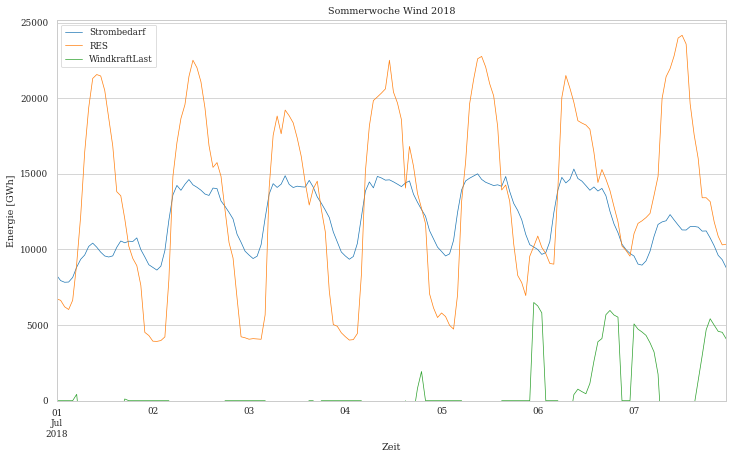

In [280]:
df[cols_wind].loc["2018-07-01":"2018-07-07"].plot(figsize=(12,7)).set(title="Sommerwoche Wind " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_wind)

## Winterwoche Wind

[Text(0.5, 1.0, 'Winterwoche Wind 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]'),
 (0.0, 25164.920649936386)]

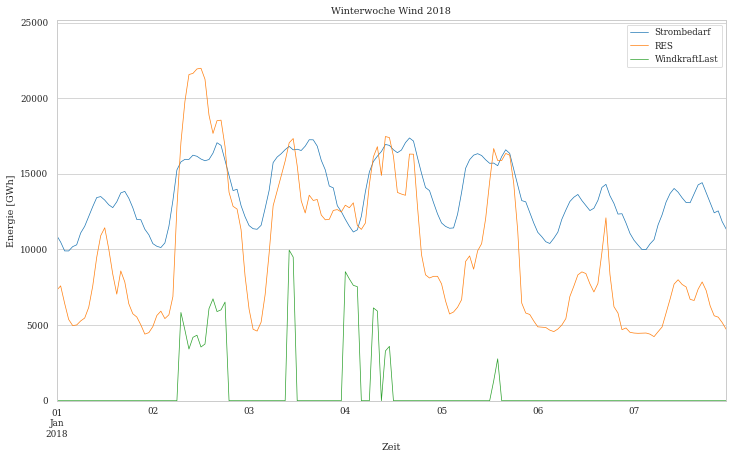

In [281]:
df[cols_wind].loc["2018-01-01":"2018-01-07"].plot(figsize=(12,7)).set(title="Winterwoche Wind " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]", ylim=ax_scale_wind)

## Signal, Nicht-Signal

In [282]:
cut = 0.4
df_sign_wind = pd.DataFrame()
for c in df.columns:
    df_sign_wind[c] = df[c].map(lambda x: -1 if x < cut else 1)


In [283]:
df_step_wind = pd.DataFrame()
df_not_wind = pd.DataFrame()

#fig, ax = plt.subplots()
for c in df_sign_wind.columns:
    df_step_wind[c] =  df_sign_wind[c].shift(1).ne(df_sign_wind[c]).where(df_sign_wind[c]==1).cumsum()
    df_not_wind[c] =  df_sign_wind[c].shift(1).ne(df_sign_wind[c]).where(df_sign_wind[c]==-1).cumsum()
df_step_wind.iloc[0,:] = 0


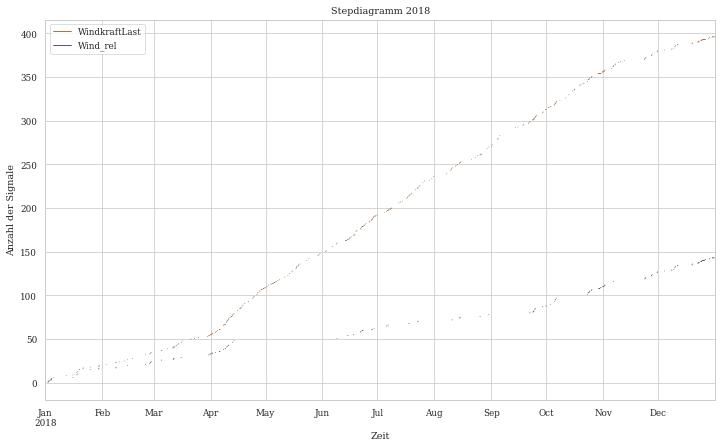

In [284]:
colsstep_wind = [
        #"Photovoltaik",
        #"Non Volatiles",
        "WindkraftLast",
        "Wind_rel",
        ]

fig, ax = plt.subplots()
df_step_wind[colsstep_wind].plot(figsize=(12,7), cmap="PuOr", grid=True, ax=ax).set(title=f"Stepdiagramm {em_year}", xlabel="Zeit", ylabel="Anzahl der Signale")

fig.savefig(f"../data/Plots/Stepdiagramm_wind_{em_year}_{cut}.png", dpi=300, bbox_inches='tight')

In [285]:
df_step_wind.fillna(0, inplace=True)
df_not_wind.fillna(0, inplace=True)

In [286]:
desc_wind = pd.DataFrame()
desc_wind["Zeitraum mit Signal [h]"] = df_sign_wind.where(df_sign_wind>0).sum()
desc_wind["Nicht-Signal-Zeitraum [h]"] = 8760 - desc_wind["Zeitraum mit Signal [h]"]
desc_wind["Anzahl Signal-Perioden"] = df_step_wind.max()
desc_wind["Durchschnittliche Dauer Signal [h]"] = (desc_wind["Zeitraum mit Signal [h]"]/desc_wind["Anzahl Signal-Perioden"])
desc_wind["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_wind["Nicht-Signal-Zeitraum [h]"]/desc_wind["Anzahl Signal-Perioden"]


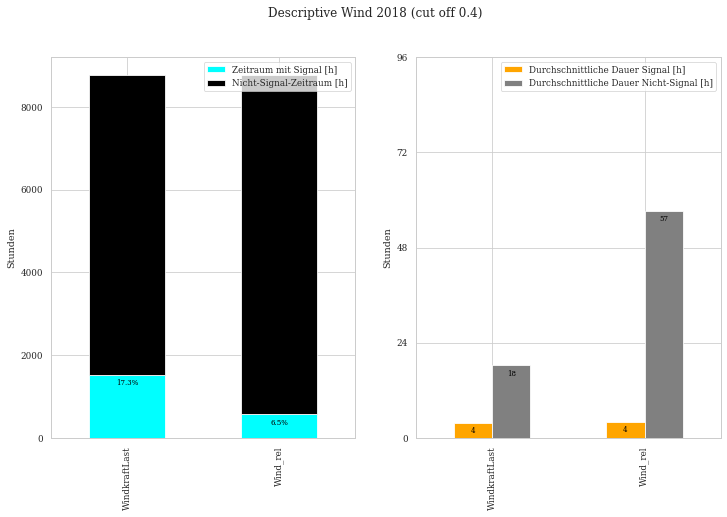

In [287]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_wind.loc[colsstep_wind][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_wind.loc[colsstep_wind][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/8760), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive Wind {em_year} (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_{cut}.png", dpi=300, bbox_inches='tight')

## Sommer - Winter - Vergleich

In [288]:
w_months=[1,2,3,10,11,12]
s_months=[4,5,6,7,8,9]

In [289]:
df_wind_sign_s = df_sign_wind.loc[(df_sign_wind.index.month >= 4) & (df_sign_wind.index.month < 10)]
df_wind_sign_w = df_sign_wind.loc[(df_sign_wind.index.month >= 10) | (df_sign_wind.index.month < 4)]

### Winter

In [290]:
df_wind_step_w = pd.DataFrame()
df_wind_not_w = pd.DataFrame()

for c in df_wind_sign_w.columns:
    df_wind_step_w[c] =  df_wind_sign_w[c].shift(1).ne(df_wind_sign_w[c]).where(df_wind_sign_w[c]==1).cumsum()
    df_wind_not_w[c] =  df_wind_sign_w[c].shift(1).ne(df_wind_sign_w[c]).where(df_wind_sign_w[c]==-1).cumsum()
df_wind_step_w.iloc[0,:] = 0

In [291]:
desc_wind_w = pd.DataFrame()
desc_wind_w["Zeitraum mit Signal [h]"] = df_wind_sign_w.where(df_wind_sign_w>0).sum()
desc_wind_w["Nicht-Signal-Zeitraum [h]"] = len(df_wind_sign_w) - desc_wind_w["Zeitraum mit Signal [h]"]
desc_wind_w["Anzahl Signal-Perioden"] = df_wind_step_w.max()
desc_wind_w["Durchschnittliche Dauer Signal [h]"] = (desc_wind_w["Zeitraum mit Signal [h]"]/desc_wind_w["Anzahl Signal-Perioden"])
desc_wind_w["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_wind_w["Nicht-Signal-Zeitraum [h]"]/desc_wind_w["Anzahl Signal-Perioden"]


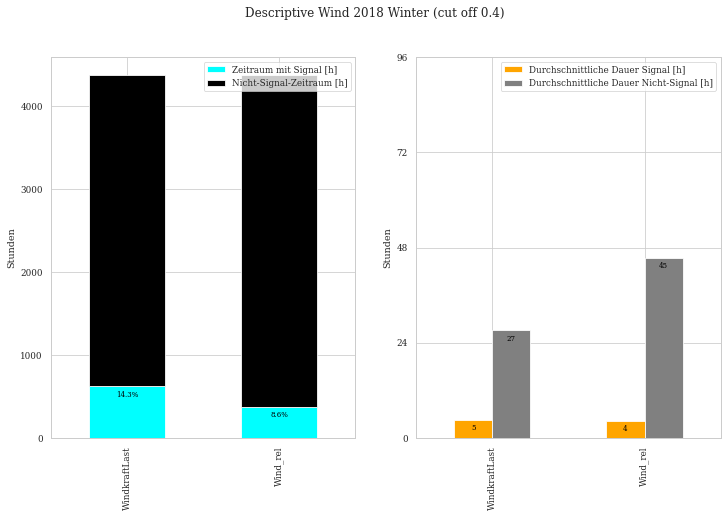

In [292]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_wind_w.loc[colsstep_wind][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_wind_w.loc[colsstep_wind][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/len(df_wind_sign_w)), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive Wind {em_year} Winter (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_winter_{cut}.png", dpi=300, bbox_inches='tight')

In [293]:
df_wind_step_s = pd.DataFrame()
df_wind_not_s = pd.DataFrame()

for c in df_wind_sign_s.columns:
    df_wind_step_s[c] =  df_wind_sign_s[c].shift(1).ne(df_wind_sign_s[c]).where(df_wind_sign_s[c]==1).cumsum()
    df_wind_not_s[c] =  df_wind_sign_s[c].shift(1).ne(df_wind_sign_s[c]).where(df_wind_sign_s[c]==-1).cumsum()
df_wind_step_s.iloc[0,:] = 0

In [294]:
desc_wind_s = pd.DataFrame()
desc_wind_s["Zeitraum mit Signal [h]"] = df_wind_sign_s.where(df_wind_sign_s>0).sum()
desc_wind_s["Nicht-Signal-Zeitraum [h]"] = len(df_wind_sign_s) - desc_wind_s["Zeitraum mit Signal [h]"]
desc_wind_s["Anzahl Signal-Perioden"] = df_wind_step_s.max()
desc_wind_s["Durchschnittliche Dauer Signal [h]"] = (desc_wind_s["Zeitraum mit Signal [h]"]/desc_wind_s["Anzahl Signal-Perioden"])
desc_wind_s["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_wind_s["Nicht-Signal-Zeitraum [h]"]/desc_wind_s["Anzahl Signal-Perioden"]

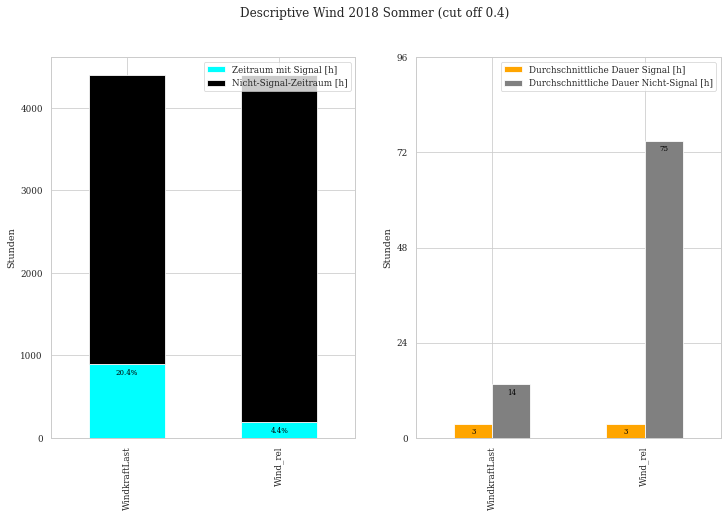

In [295]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_wind_s.loc[colsstep_wind][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_wind_s.loc[colsstep_wind][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/len(df_wind_sign_s)), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive Wind {em_year} Sommer (cut off {cut})', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_wind_{em_year}_sommer_{cut}.png", dpi=300, bbox_inches='tight')

# PV first

C:\Users\EditParáda\AppData\Local\Temp\ipykernel_10992\4150933954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PVLast[t] = df.Strombedarf[t] - df.RES[t] + df.Photovoltaik[t]


[Text(0.5, 1.0, 'PV-last 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]')]

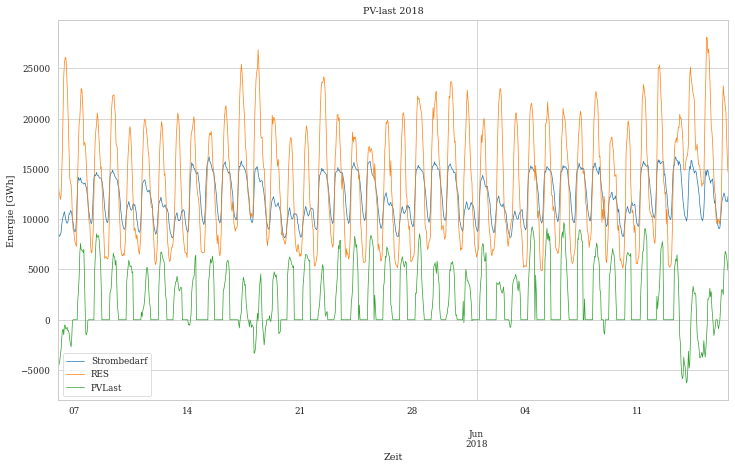

In [296]:
df["PVLast"] = 0

for t in range(8760):
    if (df.RES[t] - df.Strombedarf[t]) > 0:
        df.PVLast[t] = df.Strombedarf[t] - df.RES[t] + df.Photovoltaik[t]

cols = ["Strombedarf",
        "RES",
        "PVLast"]

df[cols].iloc[3000:4000,:].plot(figsize=(12,7)).set(title="PV-last " f"{em_year}", xlabel="Zeit", ylabel="Energie [GWh]")
#plt.axhline(y=df.Photovoltaik.max()*0.4)
#df[cols].resample("D").sum().plot(figsize=(12,7))

In [297]:
df["PV_rel"] = df.PVLast / df.Photovoltaik.max()
df_PVrel = df.PV_rel.where(df.PV_rel != 0)#.plot()

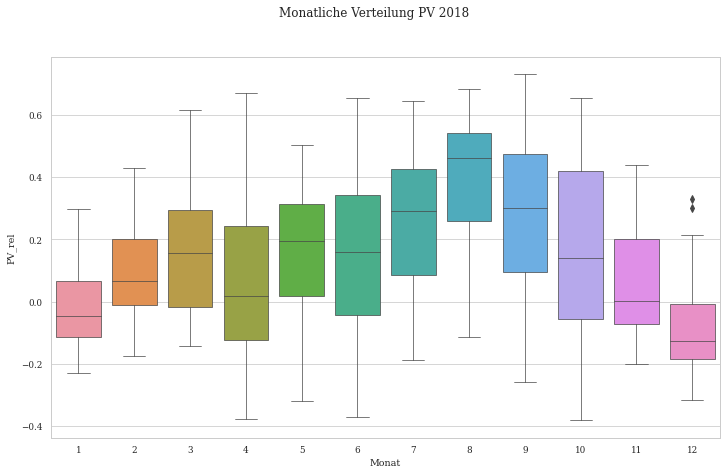

In [298]:
fig, ax = plt.subplots()
sns.boxplot(x=df_PVrel.index.month, y=df_PVrel, orient="v", ax=ax).set(xlabel='Monat')
fig.set_size_inches(12, 7)
fig.suptitle(f'Monatliche Verteilung PV {em_year}', fontsize=12)
fig.savefig(f"../data/Plots/Monatlich_PV_{em_year}.png", dpi=300, bbox_inches='tight')

[Text(0.5, 1.0, 'Sommerwoche PV 2018'),
 Text(0.5, 0, 'Zeit'),
 Text(0, 0.5, 'Energie [GWh]'),
 (0.0, 25164.920649936386)]

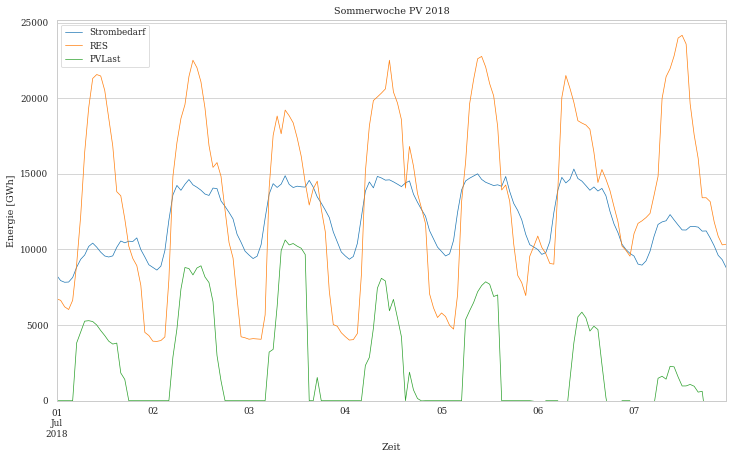

In [299]:
max_score_PV = max(max(df[cols].loc["2018-07-01":"2018-07-07"].max()),
                     max(df[cols].loc["2018-01-01":"2018-01-07"].max()))
ax_scale_PV = 0, (max_score_PV + 1000)
df[cols].loc["2018-07-01":"2018-07-07"].plot(figsize=(12, 7)).set(title="Sommerwoche PV " f"{em_year}", xlabel="Zeit",
                                                                  ylabel="Energie [GWh]", ylim=ax_scale_PV)

In [300]:
df_sign_PV = pd.DataFrame()
for c in df.columns:
    df_sign_PV[c] = df[c].map(lambda x: -1 if x < 0.00001 else 1)

df_step_PV = pd.DataFrame()
df_not_PV = pd.DataFrame()

#fig, ax = plt.subplots()
for c in df_sign_PV.columns:
    df_step_PV[c] = df_sign_PV[c].shift(1).ne(df_sign_PV[c]).where(df_sign_PV[c] == 1).cumsum()
    df_not_PV[c] = df_sign_PV[c].shift(1).ne(df_sign_PV[c]).where(df_sign_PV[c] == -1).cumsum()
df_step_PV.iloc[0, :] = 0

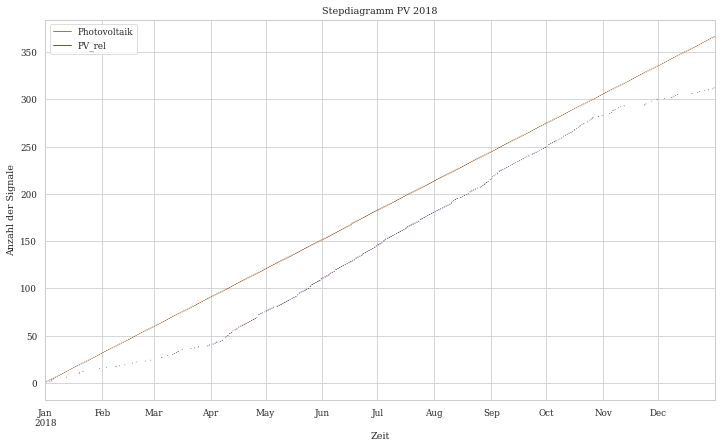

In [301]:
colsstep_PV = [
        "Photovoltaik",
        #"Non Volatiles",
        #"WindkraftLast",
        #"Wind_rel",
        "PV_rel",
        ]

fig, ax = plt.subplots()
df_step_PV[colsstep_PV].plot(figsize=(12,7), cmap="PuOr", grid=True, ax=ax).set(title=f"Stepdiagramm PV {em_year}", xlabel="Zeit", ylabel="Anzahl der Signale")

fig.savefig(f"../data/Plots/Stepdiagramm_PV_{em_year}.png", dpi=300, bbox_inches='tight')

In [302]:
df_step_PV.fillna(0, inplace=True)
df_not_PV.fillna(0, inplace=True)
desc_PV = pd.DataFrame()
desc_PV["Zeitraum mit Signal [h]"] = df_sign_PV.where(df_sign_PV > 0).sum()
desc_PV["Nicht-Signal-Zeitraum [h]"] = 8760 - desc_PV["Zeitraum mit Signal [h]"]
desc_PV["Anzahl Signal-Perioden"] = df_step_PV.max()
desc_PV["Durchschnittliche Dauer Signal [h]"] = (desc_PV["Zeitraum mit Signal [h]"] / desc_PV["Anzahl Signal-Perioden"])
desc_PV["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_PV["Nicht-Signal-Zeitraum [h]"] / desc_PV["Anzahl Signal-Perioden"]


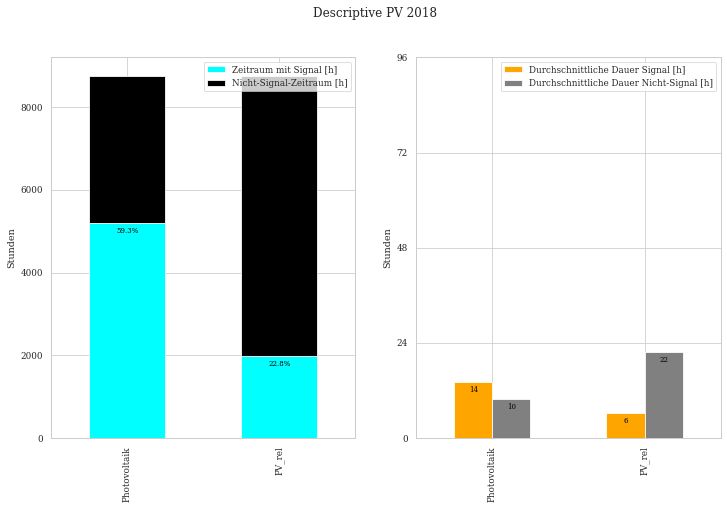

In [303]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_PV.loc[colsstep_PV][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_PV.loc[colsstep_PV][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/8760), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive PV {em_year}', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_PV_{em_year}.png", dpi=300, bbox_inches='tight')

## Sommer - Winter - Vergleich

In [304]:
df_PV_sign_s = df_sign_PV.loc[(df_sign_PV.index.month >= 4) & (df_sign_PV.index.month < 10)]
df_PV_sign_w = df_sign_PV.loc[(df_sign_PV.index.month >= 10) | (df_sign_PV.index.month < 4)]

In [305]:
df_PV_step_w = pd.DataFrame()
df_PV_not_w = pd.DataFrame()

for c in df_PV_sign_w.columns:
    df_PV_step_w[c] = df_PV_sign_w[c].shift(1).ne(df_PV_sign_w[c]).where(df_PV_sign_w[c] == 1).cumsum()
    df_PV_not_w[c] = df_PV_sign_w[c].shift(1).ne(df_PV_sign_w[c]).where(df_PV_sign_w[c] == -1).cumsum()
df_PV_step_w.iloc[0, :] = 0


In [306]:
desc_PV_w = pd.DataFrame()
desc_PV_w["Zeitraum mit Signal [h]"] = df_PV_sign_w.where(df_PV_sign_w > 0).sum()
desc_PV_w["Nicht-Signal-Zeitraum [h]"] = len(df_PV_sign_w) - desc_PV_w["Zeitraum mit Signal [h]"]
desc_PV_w["Anzahl Signal-Perioden"] = df_PV_step_w.max()
desc_PV_w["Durchschnittliche Dauer Signal [h]"] = (
            desc_PV_w["Zeitraum mit Signal [h]"] / desc_PV_w["Anzahl Signal-Perioden"])
desc_PV_w["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_PV_w["Nicht-Signal-Zeitraum [h]"] / desc_PV_w[
    "Anzahl Signal-Perioden"]

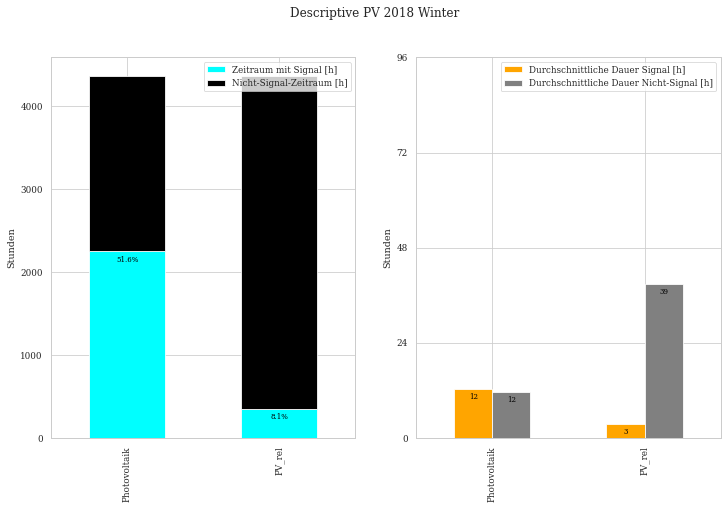

In [307]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
desc_PV_w.loc[colsstep_PV][["Zeitraum mit Signal [h]","Nicht-Signal-Zeitraum [h]"]]\
    .plot(kind="bar",color=["cyan", "black"], stacked=True, ax = ax[0]).set(ylabel="Stunden")
desc_PV_w.loc[colsstep_PV][["Durchschnittliche Dauer Signal [h]","Durchschnittliche Dauer Nicht-Signal [h]"]]\
    .plot(kind="bar",color=["orange", "grey"], stacked=False, ax = ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
     ax[0].annotate("{:.1f}%" .format(p.get_height()*100/len(df_PV_sign_w)), (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() -5), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
      ax[1].annotate("{:.0f}" .format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive PV {em_year} Winter', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_PV_{em_year}_winter.png", dpi=300, bbox_inches='tight')

In [308]:
df_PV_step_s = pd.DataFrame()
df_PV_not_s = pd.DataFrame()

for c in df_PV_sign_s.columns:
    df_PV_step_s[c] = df_PV_sign_s[c].shift(1).ne(df_PV_sign_s[c]).where(df_PV_sign_s[c] == 1).cumsum()
    df_PV_not_s[c] = df_PV_sign_s[c].shift(1).ne(df_PV_sign_s[c]).where(df_PV_sign_s[c] == -1).cumsum()
df_PV_step_s.iloc[0, :] = 0

In [309]:
desc_PV_s = pd.DataFrame()
desc_PV_s["Zeitraum mit Signal [h]"] = df_PV_sign_s.where(df_PV_sign_s > 0).sum()
desc_PV_s["Nicht-Signal-Zeitraum [h]"] = len(df_PV_sign_s) - desc_PV_s["Zeitraum mit Signal [h]"]
desc_PV_s["Anzahl Signal-Perioden"] = df_PV_step_s.max()
desc_PV_s["Durchschnittliche Dauer Signal [h]"] = (
            desc_PV_s["Zeitraum mit Signal [h]"] / desc_PV_s["Anzahl Signal-Perioden"])
desc_PV_s["Durchschnittliche Dauer Nicht-Signal [h]"] = desc_PV_s["Nicht-Signal-Zeitraum [h]"] / desc_PV_s[
    "Anzahl Signal-Perioden"]

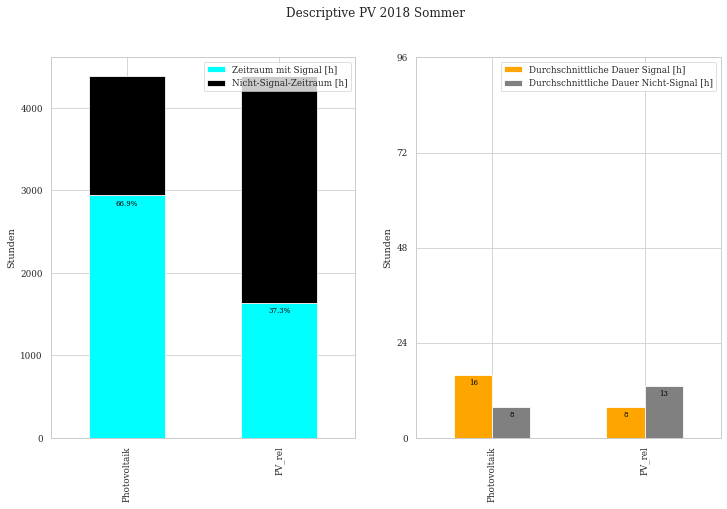

In [310]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
desc_PV_s.loc[colsstep_PV][["Zeitraum mit Signal [h]", "Nicht-Signal-Zeitraum [h]"]].plot(kind="bar", color=["cyan", "black"], stacked=True, ax=ax[0]).set(ylabel="Stunden")
desc_PV_s.loc[colsstep_PV][["Durchschnittliche Dauer Signal [h]", "Durchschnittliche Dauer Nicht-Signal [h]"]].plot(kind="bar", color=["orange", "grey"], stacked=False, ax=ax[1]).set(ylabel="Stunden")
for p in ax[0].patches:
    ax[0].annotate("{:.1f}%".format(p.get_height() * 100 / len(df_PV_sign_s)),
                   (p.get_x() + p.get_width() / 2., p.get_height() + p.get_y() - 5), ha='center', va='center',
                   fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
for p in ax[1].patches:
    ax[1].annotate("{:.0f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                   va='center', fontsize=7, color='black', xytext=(0, -8), textcoords='offset points')
ax[1].yaxis.set_ticks(np.arange(0, 97, 24))
fig.suptitle(f'Descriptive PV {em_year} Sommer', fontsize=12)
fig.savefig(f"../data/Plots/descriptive_PV_{em_year}_sommer.png", dpi=300, bbox_inches='tight')

## Stunde-Skalierung

Über acht 3-stündliche Werte wird ein spezifische Tagesverlauf generiert und für das ganze Jahr ...

array([1.275     , 1.13583918, 0.9471227 , ..., 1.025     , 1.00265922,
       1.18478107])

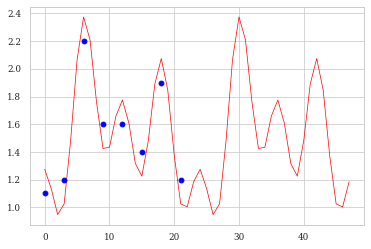

In [311]:

# apply transform
import FLUCCOplus.transform as traffo
import os

if not os.path.exists("../Data/interim"):
        os.makedirs("../Data/interim")

hscale = 24
p_day = np.array([1.1, 1.2, 2.2, 1.6, 1.6, 1.4, 1.9, 1.2])
day = traffo.transform(p_day, hour_scale=hscale)

x = np.arange(0, hscale, hscale/len(p_day))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day[:hscale*2], "r")
plt.plot(x[:hscale*2], p_day[:hscale*2], "bo")

#np.savetxt(config.DATA_INTERIM / Path("tagesverlauf.csv"), day, format("%2.4f"))
day

In [312]:
day.sum()

13359.0

Über acht Skalierfaktor wird ein "Skalierverlauf" für das ganze Jahr generiert...

array([1.0125    , 0.97181439, 0.94749649, ..., 0.9875    , 1.01410605,
       1.02898252])

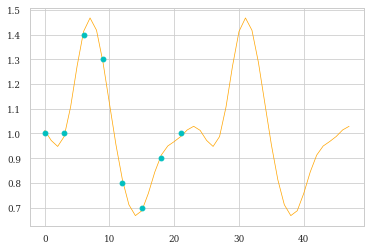

In [313]:
import numpy as np
p_day_scaler = [1, 1, 1.4, 1.3, 0.8, 0.7, 0.9, 1] # hours are in 3-hour-steps
day_scaler = traffo.transform(p_day_scaler, hour_scale=hscale)


x = np.arange(0, hscale, hscale/len(p_day_scaler))
xh = np.arange(0,8760,1)
plt.plot(xh[:hscale*2], day_scaler[:hscale*2], "orange")
plt.plot(x[:hscale*2], p_day_scaler[:hscale*2], "co")

day_scaler

Der spezifische Jahresverlauf wird mit dem "Skalierverlauf" multipliziert...

In [314]:
scaled_day = np.multiply(day,day_scaler)
scaled_day

array([1.2909375 , 1.10382487, 0.89739543, ..., 1.0121875 , 1.01680279,
       1.21911901])

In [315]:
scaled_day.sum()

13849.012499999997

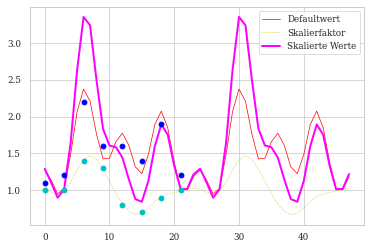

In [316]:
x = np.arange(0, hscale, hscale/len(p_day_scaler))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day[:hscale*2], "r")

plt.plot(xh[:hscale*2], day_scaler[:hscale*2], "y:")

plt.plot(xh[:hscale*2], scaled_day[:hscale*2], "magenta", linewidth=2.0)
plt.legend(['Defaultwert', 'Skalierfaktor', 'Skalierte Werte'])
plt.plot(x[:hscale*2], p_day[:hscale*2], "bo")
plt.plot(x[:hscale*2], p_day_scaler[:hscale*2], "co")
plt.savefig('../Data/interim/Default_skaliert.png', dpi=300)

Skalierfaktor zu dem Zielwert wird ermittelt...

In [317]:
target_value=s.TSD.Strombedarf.sum()/1000
target_value

115805.56482000001

In [318]:
scale_factor = target_value / scaled_day.sum()
scale_factor

8.36200883059352

Die 3-stündliche Werte werden hochskaliert...

In [319]:
p_day_to_target = p_day * scale_factor
p_day_to_target

array([ 9.19820971, 10.0344106 , 18.39641943, 13.37921413, 13.37921413,
       11.70681236, 15.88781678, 10.0344106 ])

und der Jahresverlauf wird durch das Tagesprofil generiert...

<AxesSubplot:>

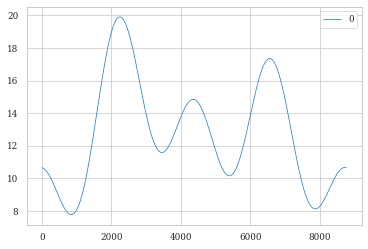

In [320]:
day_to_target = traffo.transform(p_day_to_target, hour_scale=8760)
pd.DataFrame(day_to_target).plot()

<AxesSubplot:xlabel='datetime'>

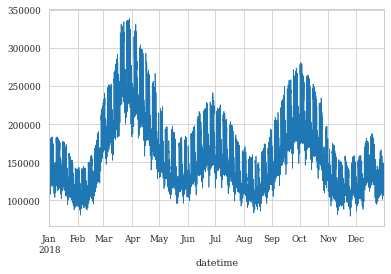

In [321]:
df_scaled = s.TSD["Strombedarf"] * day_to_target
df_scaled.plot()

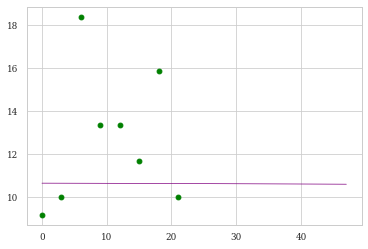

In [322]:

x = np.arange(0, hscale, hscale/len(p_day_to_target))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day_to_target[:hscale*2], "purple")
plt.plot(x[:hscale*2], p_day_to_target[:hscale*2], "go")

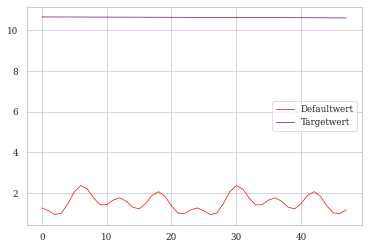

In [323]:
x = np.arange(0, hscale, hscale/len(p_day_to_target))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day[:hscale*2], "r")
plt.plot(xh[:hscale*2], day_to_target[:hscale*2], "purple")
plt.legend(['Defaultwert', 'Targetwert'])
#plt.plot(x[:hscale*2], p_day[:hscale*2], "bo")
#plt.plot(x[:hscale*2], p_day_to_target[:hscale*2], "go")
plt.savefig('../Data/interim/Default_and_Targetvalue.png', dpi=300)

Der skalierte Jahresverlauf wird mit dem Skalierverlauf multipliziert...

In [324]:
scaled_day_to_target = np.multiply(day_to_target,day_scaler)
scaled_day_to_target

array([10.79483077, 10.36041788, 10.1005268 , ..., 10.53014836,
       10.8132415 , 10.97122183])

In [325]:
scaled_day_to_target.sum()

113104.42691749758

In [326]:
target_value

115805.56482000001

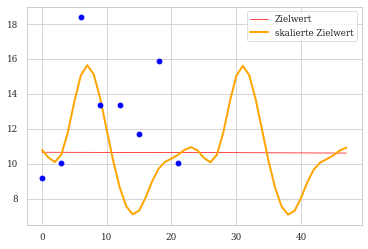

In [327]:
x = np.arange(0, hscale, hscale/len(p_day_to_target))
xh = np.arange(0,8760,1)

plt.plot(xh[:hscale*2], day_to_target[:hscale*2], "r")
plt.plot(xh[:hscale*2], scaled_day_to_target[:hscale*2], "orange", linewidth=2.0)

plt.legend(['Zielwert', 'skalierte Zielwert'])
plt.plot(x[:hscale*2], p_day_to_target[:hscale*2], "bo")
plt.savefig('../Data/interim/skalierte_Default_and_Targetvalue.png', dpi=300)

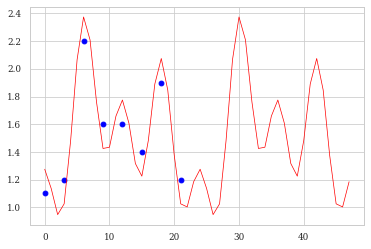

In [328]:
import panel as pn
import panel.widgets as pnw
from matplotlib.figure import Figure

def scaler_plot(scaler, support_points, hour_scale, view_scale=2):
    """
    scaler: zeitreihe (8760)
    
    """
    p, h = support_points, hour_scale

    x = np.arange(0, h, h/len(p))
    xh = np.arange(0,8760,1)

    fig = Figure()
    ax = fig.add_subplot()
    a, b = 0, int(h*view_scale)
    ax.plot(x[a:b], p[a:b], "bo")
    ax.plot(xh[a:b], scaler[a:b], "r")
    return fig

scaler_plot(day,p_day, 24)

Row
    [0] Column
        [0] Column
            [0] Markdown(str)
        [1] FloatSlider(end=3.0, step=0.05, value=1.0)
        [2] FloatSlider(end=3.0, step=0.05, value=1.0)
        [3] FloatSlider(end=3.0, step=0.05, value=1.0)
        [4] FloatSlider(end=3.0, step=0.05, value=1.0)
        [5] FloatSlider(end=3.0, step=0.05, value=1.0)
        [6] FloatSlider(end=3.0, step=0.05, value=1.0)
        [7] FloatSlider(end=3.0, step=0.05, value=1.0)
        [8] FloatSlider(end=3.0, step=0.05, value=1.0)
        [9] FloatSlider(end=3.0, step=0.05, value=1.0)
        [10] FloatSlider(end=3.0, step=0.05, value=1.0)
        [11] FloatSlider(end=3.0, step=0.05, value=1.0)
        [12] FloatSlider(end=3.0, step=0.05, value=1.0)
    [1] ParamFunction(function)
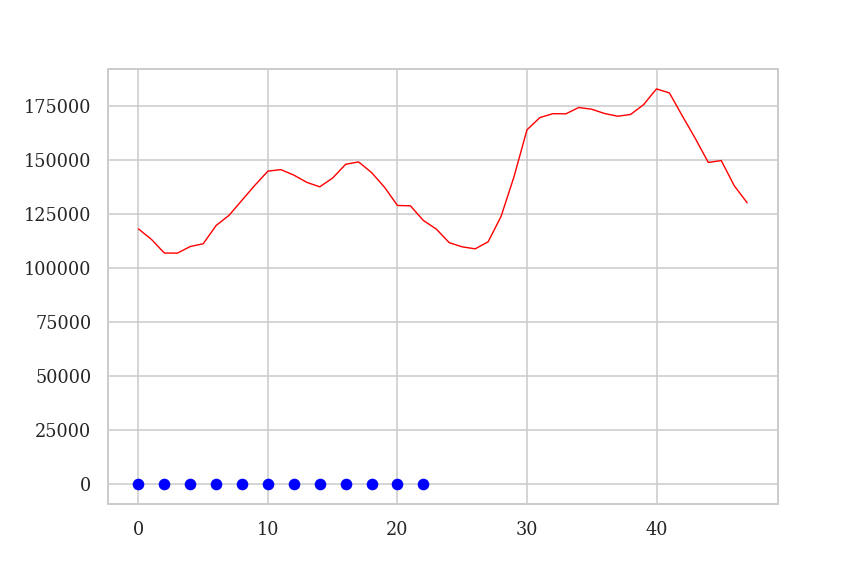

In [329]:
#params
N = 12 # muss eigentlich anzahl der skalierungswerte sein
zyklus = 24 #h zyklus
timeseries = df_scaled


points = [pnw.FloatSlider(name='', value=1.0, start=0., end=3., step=0.05) for i in range(N)]
#points = np.array(p_day_scaler)
#points = [pnw.FloatSlider(name='', value=1.0, start=0., end=3., step=0.05) for i in range(N)]
@pn.depends(*points)
def reactive_scalar(*points):
    p = np.array(p_day_scaler)
    transformed_timeseries = timeseries * traffo.transform(p)
    return scaler_plot(transformed_timeseries, points, zyklus)

widgets   = pn.Column("<br>\n# Reactive Scaler")
sliders = pn.Column(widgets, *points)
dashboard = pn.Row(sliders, reactive_scalar)

pn.extension()
pn.interact()
dashboard

## Monate-Skalierung

In [330]:
type(day_to_target)

numpy.ndarray

In [331]:
month_values = np.divide(day_to_target,730)
for i in range(12):
    month_values[i] = day_to_target


ValueError: setting an array element with a sequence.

In [ ]:
# scale to fit targetsum

# get load
# apply transform
#     ecars (non dsm)
#
# scale to fit targetsum

# em scenario residual load report